# Machine Learning - Orders

O presente arquivo tem por objetivo a criação de um algoritimo de machine learning capaz de prever com base nos dados de entregas e pedidos, se um determinado pedido será entregue ou cancelado.<br>
Para isso, iremos utilizar dois datasets, sendo eles: <b>deliveries.csv</b> e <b>orders.csv</b>; realizando a junção dos mesmos para utilizar seus relacionamentos e extrair a features necessárias.



In [80]:
# Importanto bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import TomekLinks
#%pip install imblearn
import imblearn

%matplotlib inline

In [2]:
# Realizando leitura dos datasets
deliveries = pd.read_csv('dados/deliveries.csv')
order = pd.read_csv('dados/orders.csv')

# Realizando um Merge dos dataset para analisar melhor a relação dos dados
dataset = pd.merge(deliveries, order, on='delivery_order_id')

## Análise Exploratória dos dados

In [3]:
# Preview dos dados
dataset.head()

,delivery_id,delivery_order_id,driver_id,delivery_distance_meters,delivery_status,order_id,store_id,channel_id,payment_order_id,order_status,...,order_moment_delivering,order_moment_delivered,order_moment_finished,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
0,2174658,68413340,8378.0,5199.0,DELIVERED,68413340,631,5,68413340,FINISHED,...,1/1/2021 2:42:08 PM,NaN,1/1/2021 3:31:54 PM,7.03,3.10,14.62,9.57,12.67,49.78,77.05
1,2174660,68414309,2473.0,410.0,DELIVERED,68414309,236,5,68414309,FINISHED,...,1/1/2021 2:43:36 PM,NaN,1/1/2021 2:50:20 PM,2.37,1.45,15.78,5.33,6.78,6.73,29.30
2,2174661,68416230,7615.0,3784.0,DELIVERED,68416230,1016,5,68416230,FINISHED,...,1/1/2021 2:48:05 PM,NaN,1/1/2021 2:57:36 PM,1.57,0.93,4.20,2.27,3.20,9.52,16.92
3,2174663,68412721,8378.0,5714.0,DELIVERED,68412721,631,5,68412721,FINISHED,...,1/1/2021 2:49:18 PM,NaN,1/1/2021 4:12:36 PM,0.27,10.22,26.07,0.83,11.05,83.30,120.42
4,2174675,68414018,10463.0,3746.0,DELIVERED,68414018,3265,5,68414018,FINISHED,...,1/1/2021 2:58:17 PM,NaN,1/1/2021 3:09:20 PM,10.22,3.03,27.48,10.25,13.28,11.05,51.82


In [4]:
# Verificando Shape dos dados
# Podemos ver que o numero de registros no dataset é bastante elevado, por isso, devemos realizar posteriormente
# uma limpeza nos dados para ter uma melhor performance.
dataset.shape

(378843, 33)

In [5]:
# Após analisar os dados, iremos remover algumas colunas não relevantes para análise e criaremos um novo subset de dados

subset = dataset[['delivery_distance_meters', 'delivery_status', 'order_status', 'order_amount',
       'order_delivery_fee', 'order_delivery_cost', 'order_created_hour',
       'order_created_minute', 'order_created_month',         
       'order_metric_collected_time', 'order_metric_paused_time',
       'order_metric_production_time', 'order_metric_walking_time',
       'order_metric_expediton_speed_time', 'order_metric_transit_time',
       'order_metric_cycle_time']]

subset.head()

,delivery_distance_meters,delivery_status,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_month,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
0,5199.0,DELIVERED,FINISHED,46.90,11.90,11.36,14,14,1,7.03,3.10,14.62,9.57,12.67,49.78,77.05
1,410.0,DELIVERED,FINISHED,94.90,11.90,6.00,14,21,1,2.37,1.45,15.78,5.33,6.78,6.73,29.30
2,3784.0,DELIVERED,FINISHED,39.80,6.99,9.75,14,40,1,1.57,0.93,4.20,2.27,3.20,9.52,16.92
3,5714.0,DELIVERED,FINISHED,195.05,11.90,10.93,14,12,1,0.27,10.22,26.07,0.83,11.05,83.30,120.42
4,3746.0,DELIVERED,FINISHED,45.80,0.00,10.28,14,17,1,10.22,3.03,27.48,10.25,13.28,11.05,51.82


#### Possível problema:
<br>
Ao analisar os dados, percebemos que há um possível erro relacionado aos campos "delivery_status" e "order_status".  <br>
Se um pedido "order_status" é cancelado, em teoria, não seria possível que o mesmo ter sido entregue (a não ser que haja 
alguma regra ne negócio que viabilizaria essa situação), porém os dados nos mostra algumas dessas situações que precisariam ser verificadas com a equipe de negócio para um melhor entendimento.
conforme resultado abaixo:


In [6]:
subset[(subset['delivery_status'] == 'DELIVERED') & (subset['order_status'] == 'CANCELED')].head()

,delivery_distance_meters,delivery_status,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_month,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
202,5460.0,DELIVERED,CANCELED,124.0,11.9,0.00,16,20,1,3.83,NaN,21.08,8.47,NaN,NaN,NaN
220,2363.0,DELIVERED,CANCELED,59.8,0.0,8.09,15,57,1,1.32,14.8,39.98,1.42,16.22,67.58,123.78
332,2849.0,DELIVERED,CANCELED,115.8,11.9,0.00,17,33,1,6.87,NaN,22.87,10.63,NaN,NaN,NaN
334,3771.0,DELIVERED,CANCELED,79.7,11.9,0.00,17,29,1,0.90,NaN,11.05,0.90,NaN,NaN,NaN
410,3121.0,DELIVERED,CANCELED,197.6,11.9,0.00,18,0,1,1.47,NaN,21.97,9.17,NaN,NaN,NaN


### Verificando a quantidade de registros para cada possibilidade da variável target
Podemos ver no grafico a baixo que, estamos lidando com dados desbalanceados, devido a grande quantidade de dados voltados para os pedidos que foram entregues, e as demais quantidades. Isso é um problema pois, devido ao desbalanceamento dos dados, qualquer algoritimo que recebê-los, terá uma tendencia a classificar os dados como entregue "DELIVERED".<br>

<AxesSubplot:xlabel='delivery_status', ylabel='count'>

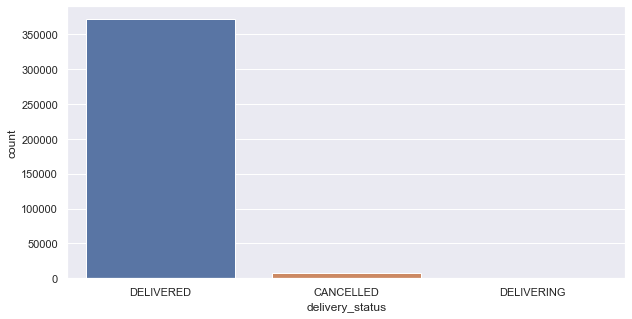

In [7]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
sns.countplot(x=subset.delivery_status)

#### Verficando valores missing
<br>
Podemos ver abaixo que 8 colunas do dataset possuem valores missing que devem ser tratados

In [8]:
# Nesta parte, iremos utilizar a função isnull() para verificar quais colunas apresentam valores missing
# Esta etapa é bastante importante, pois podem acarretar erros nos algoritmos caso não sejam tratados com antecedencia.
subset.isnull().sum()

delivery_distance_meters                73
delivery_status                          0
order_status                             0
order_amount                             0
order_delivery_fee                       0
order_delivery_cost                   5308
order_created_hour                       0
order_created_minute                     0
order_created_month                      0
order_metric_collected_time          43943
order_metric_paused_time             64183
order_metric_production_time         18891
order_metric_walking_time            67318
order_metric_expediton_speed_time    25943
order_metric_transit_time            16461
order_metric_cycle_time               7900
dtype: int64

## Pré-Processamento de Dados
<br>
Nesta etapa, realizaremos a manipulação dos dados afim de resolver os problemas encontrados na análise exploratória dos mesmos na etapa anterior.

### 1° Passo: Limpeza dos dados
<br>
Como o objetivo do algoritimo é prever se um pedido será Cancelado ou Entregue, podemos remover as linhas dos pedidos que possuem o status <b>"DELIVERED"</b>.
Também iremos remover a coluna <b>"order_status"</b>, pois a mesma pode gerar uma situação de colineariedade nos dados.

In [9]:
# Removendo registros onde o delivery_status é igual a "DELIVERING"
# Para isso, iremos criar um novo subset de dados para fins de rastreabilidade
subset2 = subset[subset['delivery_status'] != 'DELIVERING']

# Removendo coluna order_status
subset2 = subset2.drop('order_status',1)
# Verificando dados
subset2.head()

,delivery_distance_meters,delivery_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_month,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
7,2564.0,CANCELLED,121.1,11.9,0.00,15,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,2100.0,CANCELLED,184.6,11.9,3.84,15,29,1,2.43,23.30,18.98,2.53,25.83,16.55,61.37
87,2995.0,CANCELLED,143.8,11.9,5.07,15,38,1,2.15,10.13,16.90,2.22,12.35,17.80,47.05
162,3958.0,CANCELLED,83.6,9.9,0.00,16,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,5460.0,CANCELLED,124.0,11.9,0.00,16,20,1,3.83,NaN,21.08,8.47,NaN,NaN,NaN


### 2° Passo: Manipulação das variáveis Target
<br>
Também é necessário fazer um tratamento das variáveis Target (variáveis que queremos prever), pois, as mesmas estão no formato de caracteres, e isso é um problema para alguns algoritimos, pois os mesmos esperam receber valores numéricos.<br>
Para isso, iremos assumir os seguintes valores:<br>
0 - <b>CANCELLED<b> <br>
1 - <b>DELIVERED<b>

In [10]:
# Para realizar a ação acima, utilizaremos um conceito muito interessante e performático chamado List comprehension
subset2['delivery_status'] = [0 if x == 'CANCELLED' else 1 for x in subset2.delivery_status]
subset2.head()

,delivery_distance_meters,delivery_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_month,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
7,2564.0,0,121.1,11.9,0.00,15,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,2100.0,0,184.6,11.9,3.84,15,29,1,2.43,23.30,18.98,2.53,25.83,16.55,61.37
87,2995.0,0,143.8,11.9,5.07,15,38,1,2.15,10.13,16.90,2.22,12.35,17.80,47.05
162,3958.0,0,83.6,9.9,0.00,16,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,5460.0,0,124.0,11.9,0.00,16,20,1,3.83,NaN,21.08,8.47,NaN,NaN,NaN


### 3° Passo: Tratamento de Valores Missing
<br>
Outro problema encontrado na análise exploratória de dados foi a grande ocorrência de valores missing nos registros.<br>
Existem várias formas de se tratar esse problema, como por exemplo:

<ul>
<li>Remoção dos valores nulos</li>
<li>Substituição pelo Ultimo valor Válido</li>
<li>Substituição pela média / moda ou mediana</li>
<li>Utilização de zeros</li>
<br>
Porém, para esse caso, iremos utilizar a substituição pela média, para analisar como o algoritimo irá se comportar.

In [11]:
# Podemos utilizar a função fillna() para realizar essa operação, passando como parâmetro a média
subset2 = subset2.fillna(subset2.mean())

In [12]:
# Verificando se ainda existem valores missing remanescentes:
subset2.isnull().sum()

delivery_distance_meters             0
delivery_status                      0
order_amount                         0
order_delivery_fee                   0
order_delivery_cost                  0
order_created_hour                   0
order_created_minute                 0
order_created_month                  0
order_metric_collected_time          0
order_metric_paused_time             0
order_metric_production_time         0
order_metric_walking_time            0
order_metric_expediton_speed_time    0
order_metric_transit_time            0
order_metric_cycle_time              0
dtype: int64

In [13]:
# Verficando dados
subset2.head()

,delivery_distance_meters,delivery_status,order_amount,order_delivery_fee,order_delivery_cost,order_created_hour,order_created_minute,order_created_month,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time
7,2564.0,0,121.1,11.9,0.00,15,0,1,3.669209,66.978881,59.226938,10.253333,70.313614,751.864981,889.021621
65,2100.0,0,184.6,11.9,3.84,15,29,1,2.430000,23.300000,18.980000,2.530000,25.830000,16.550000,61.370000
87,2995.0,0,143.8,11.9,5.07,15,38,1,2.150000,10.130000,16.900000,2.220000,12.350000,17.800000,47.050000
162,3958.0,0,83.6,9.9,0.00,16,11,1,3.669209,66.978881,59.226938,10.253333,70.313614,751.864981,889.021621
203,5460.0,0,124.0,11.9,0.00,16,20,1,3.830000,66.978881,21.080000,8.470000,70.313614,751.864981,889.021621


### Análise de Correlação
<br>
Podemos analisar no gráfico, as correlações entre as features, podemos ver que, algumas variáveis possuem uma correlação levemente positiva e negativa com a nossa variável target, o que é bom para o modelo; entretanto, é importante frizar que <b>Correlação</b> não implica <b>Causalidade</b>.
Outro ponto importante que podemos observar é que, de acordo com o grafico, algumas variáveis estão dando sinais de colineariedade, ou seja, algumas delas estão retornando o mesmo tipo de informação para o algoritimo, mesmo sendo colunas diferentes.

<AxesSubplot:>

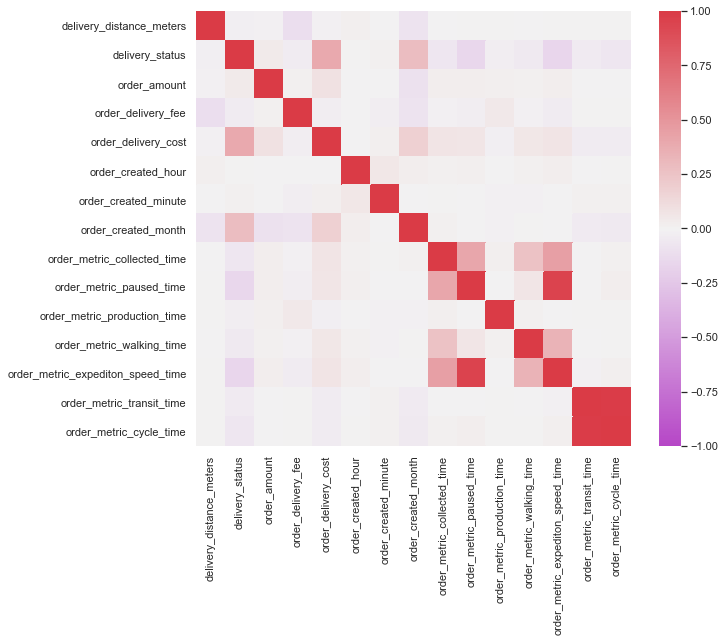

In [14]:
# Verificando correlação entre os dados
import warnings
warnings.filterwarnings("ignore")
corr = subset2.corr()

f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corr, vmin = -1, vmax = 1, mask = np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(300, 10, as_cmap=True),
           square=True, ax=ax)

# Machine Learning

<br>
Antes da aplicação e treinamento do modelo, é necessário verificar se os dados estão balanceados para evitar modelos tendenciosos. Podemos ver no resultado abaixo que os dados continuam desbalanceados com uma grande discrepância entre eles, se formos aplicar um modelo de machine learning, possívelmente obteriamos uma modelo tendencioso.
Para resolver esse problema, utilizaremos 2 tecnicas de balanceamendo de dados, e utilizaremos a que tiver o melhor resultado. São elas:<br>

<ul>
  <li><b>UnderSampling</b>: Consiste na remoção de registros da classe majoritária afim de balancear com a classe minoritária.</li>
  <li><b>OverSampling</b>: Consiste em uma técnica de criação de novos registros para uma classe minoritária baseadas nos registros mais próximos.</li>
</ul>  


In [15]:
subset2.delivery_status.value_counts()

0    7253
1     223
Name: delivery_status, dtype: int64

### Aplicação de ML nos dados sem balanceamento

In [56]:
# Primeiro teremos que dividir os dados em Features e Target para posteriormente dividirmo em treino e teste
X = subset2.drop('delivery_status',1).values
Y = subset2.iloc[:,1]

In [24]:
# Dividindo os dados em treino e Teste
# Neste caso, iremos querer uma amostra estratificada, utilizando 30% dos dados para teste
x_treino, x_teste, y_treino, y_teste = train_test_split(X,Y, test_size=0.3, stratify=Y)

In [77]:
modelo_v1 = DecisionTreeClassifier()
modelo_v1.fit(x_treino, y_treino)
previsoes = modelo_v1.predict(x_teste)
print(f'O algoritimo sem Balanceamento alcançou {(accuracy_score(y_teste, previsoes)*100):.2f} de Acuracidade')

O algoritimo sem Balanceamento alcançou 98.48 de Acuracidade


### Aplicação de ML nos dados utilizando Tecnincas de UnderSampling

In [31]:
# Instanciando
tl = TomekLinks(sampling_strategy='majority')
x_under, y_under = tl.fit_resample(X,Y)

In [47]:
# Dividindo os dados após a tecnica aplicada
x_treino_u, x_teste_u, y_treino_u, y_teste_u = train_test_split(x_under, y_under, test_size=0.3, stratify=y_under)

In [78]:
# Instânciando e treinando modelo
modelo_v2 = DecisionTreeClassifier()
modelo_v2.fit(x_treino_u, y_treino_u)
previsoes_u = modelo_v2.predict(x_teste_u)
print(f'O algoritimo balanceado com UnderSampling alcançou {(accuracy_score(y_teste_u, previsoes_u)*100):.2f} de Acuracidade')

O algoritimo balanceado com UnderSampling alcançou 99.10 de Acuracidade


### Aplicação de ML nos dados utilizando Tecnincas de OverSampling

In [50]:
# Instânciando SMOTE
smote = SMOTE(sampling_strategy='minority')

In [60]:
# Aplicando tecnica aos dados
X_over, Y_over = smote.fit_resample(X,Y)

In [63]:
# Verificando a quantidade de dados por classe na população
# Conseguimos ver que as classes possuem a mesma quantidade de registro para ambas
np.unique(Y_over, return_counts=True)

(array([0, 1], dtype=int64), array([7253, 7253], dtype=int64))

In [64]:
# Dividindo os novos dados
x_treino_o, x_teste_o, y_treino_o, y_teste_o = train_test_split(X_over, Y_over, test_size=0.3, stratify=Y_over)

In [79]:
modelo_v3 = DecisionTreeClassifier()
modelo_v3.fit(x_treino_o, y_treino_o)
previsoes_o = modelo_v3.predict(x_teste_o)
accuracy_score(previsoes_o, y_teste_o)

print(f'O algoritimo balanceado com OverSampling alcançou {(accuracy_score(y_teste_o, previsoes_o)*100):.2f} de Acuracidade')

O algoritimo balanceado com OverSampling alcançou 98.92 de Acuracidade


### Resultado
<br>
O algoritimo que teve o melhor resultado, foi o <b>modelo_v2</b>, que obteve um resultado maior utilizando a técnica de UnderSampling; não significa que essa é a melhor tecnica em todos os casos, porém, nesse algoritimo e com esses dados, a melhor opção foi utilizar tecnicas de undersampling.<BR><br><b>OBS:</b>  Como o algoritimo teve um resultado alto logo de início, seria necesserário realizar mais investigações para analisar a existência de overfitting.
<br>
    <br>
Vamos analisar agora a matriz de confusão para verficar a porcentagem de erro e acerto para cada classe

In [82]:
confusion_matrix(previsoes_u, y_teste_u)

array([[2157,   12],
       [   8,   55]], dtype=int64)

In [87]:
# Calculando a porcentagem de acerto para cada uma das classes baseados no resultado
acerto_entregues =  (2157 /(2157 + 12))*100
acerto_cancelados = (55 / (55+8))*100

In [90]:
print(f'ENTREGUES: {acerto_entregues:.2f}% \nCANCELADOS: {acerto_cancelados:.2f}')

ENTREGUES: 99.45% 
CANCELADOS: 87.30


### Conclusão
Portanto, podemos verificar que, o algoritimo tem mais facilidade em classificar entregas que serão concluídas com sucesso do que entregas que serão canceladas.  
Neste exemplo, não foi utilizado otimização de hiper-parâmetros, que poderia ajudar a reduzir ainda mais os erros. Caso as taxas de erros nao fossem aceitáveis, poderiamos utilizar por exemplo o GridSearchCV para encontrar os melhores parâmetros e obter melhores resultados.